<a href="https://colab.research.google.com/github/RoseLiu1202/Deep-Supervised-MRI-Reconstruction/blob/main/MRIReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.model_selection import train_test_split
from torch.optim import Adam

# Setting up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/dataset.hdf5'
file = h5py.File(file_path, 'r')
csm = np.array(file['trnCsm'])  # Coil sensitivity map
x_i = np.array(file['trnOrg'])  # Ground truth (original, high quality MRI images)
P_i = np.array(file['trnMask'])  # Corresponding sampling operator
file.close()

Mounted at /content/drive


In [5]:
# DATA PREPROCESSING
def normalize_images(images):
    normalized_images = np.empty(images.shape, dtype=np.float32)
    for i, image in enumerate(images):
        magnitude = np.abs(image)
        min_val = magnitude.min()
        max_val = magnitude.max()
        range_val = max_val - min_val
        if range_val == 0:
            range_val = 1e-6  # To avoid division by zero
        normalized_images[i] = (magnitude - min_val) / range_val
    return normalized_images

def forward_calculation(image, coil_sensitivity, undersampling_mask, num_rows, num_cols, num_coils):
    combined_image = np.reshape(image, (num_rows, num_cols))
    coil_combined_images = np.tile(combined_image, [num_coils, 1, 1]) * coil_sensitivity
    kspace = np.fft.fft2(coil_combined_images) / np.sqrt(num_rows * num_cols)
    if len(undersampling_mask.shape) == 2:
        undersampling_mask = np.tile(undersampling_mask, (num_coils, 1, 1))
    res = kspace[undersampling_mask != 0]
    return res

def adjoint_calculation(kspace_under, coil_sensitivity, undersampling_mask, num_rows, num_cols, num_coils):
    temp = np.zeros((num_coils, num_rows, num_cols), dtype=np.complex64)
    if len(undersampling_mask.shape) == 2:
        undersampling_mask = np.tile(undersampling_mask, (num_coils, 1, 1))
    kspace_under_reshaped = kspace_under.reshape(num_coils, -1)
    for coil_index in range(num_coils):
        coil_mask = undersampling_mask[coil_index]
        temp[coil_index][coil_mask != 0] = kspace_under_reshaped[coil_index, :coil_mask.sum()]
    inverse_fft_img = np.fft.ifft2(temp) * np.sqrt(num_rows * num_cols)
    combined_coil_image = np.sum(inverse_fft_img * np.conj(coil_sensitivity), axis=0).astype(np.complex64)
    return combined_coil_image

def handle_complex(data):
    real_part = data.real
    imag_part = data.imag
    processed_data = np.stack((real_part, imag_part), axis=1)
    return processed_data.astype(np.float32)  # Ensure float32 dtype

In [17]:
# DnCNN model definition
class DnCNN(nn.Module):
    def __init__(self, depth=20, n_channels=128, image_channels=2, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        padding = 1
        layers = [nn.Conv2d(image_channels, n_channels, kernel_size, padding=padding, bias=True), nn.ReLU(inplace=True)]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size, padding=padding, bias=not use_bnorm))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, image_channels, kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        return self.dncnn(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [18]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs, device):
    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, (x_bi, x_i) in enumerate(train_loader):
            x_bi, x_i = x_bi.to(device), x_i.to(device)

            optimizer.zero_grad()
            outputs = model(x_bi)
            loss = criterion(outputs, x_i)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_bi, x_i in val_loader:
                x_bi, x_i = x_bi.to(device), x_i.to(device)
                outputs = model(x_bi)
                val_loss += criterion(outputs, x_i).item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


In [19]:
normalized_x_i = normalize_images(x_i)
y_i = []
xbi = []

for i in range(normalized_x_i.shape[0]):
    num_rows, num_cols = normalized_x_i[i].shape
    num_coils = csm.shape[1]
    undersampled_kspace = forward_calculation(
        normalized_x_i[i], csm[i], P_i[i], num_rows, num_cols, num_coils)
    y_i.append(undersampled_kspace)
    reconstructed_image = adjoint_calculation(
        undersampled_kspace, csm[i], P_i[i], num_rows, num_cols, num_coils)
    xbi.append(reconstructed_image)

normalized_xbi = normalize_images(np.array(xbi))

# Split the data
x_bi_train_test, x_bi_val, x_i_train_test, x_i_val = train_test_split(normalized_xbi, normalized_x_i, test_size=0.2, random_state=42)
x_bi_train, x_bi_test, x_i_train, x_i_test = train_test_split(x_bi_train_test, x_i_train_test, test_size=0.25, random_state=42)

# Handle complex data
x_bi_train = handle_complex(x_bi_train)
x_bi_val = handle_complex(x_bi_val)
x_i_train = handle_complex(x_i_train)
x_i_val = handle_complex(x_i_val)
x_bi_test = handle_complex(x_bi_test)
x_i_test = handle_complex(x_i_test)

# Create TensorDataset for training and validation
train_dataset = TensorDataset(torch.from_numpy(x_bi_train), torch.from_numpy(x_i_train))
val_dataset = TensorDataset(torch.from_numpy(x_bi_val), torch.from_numpy(x_i_val))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Initialize model
model = DnCNN().to(device)

# Train the model
num_epochs = 50
train_model(model, train_loader, val_loader, num_epochs, device)

print("Training completed.")

# Save the model
torch.save(model.state_dict(), 'dncnn_mri_model.pth')

Epoch [1/50], Step [10/27], Loss: 0.0732
Epoch [1/50], Step [20/27], Loss: 0.0176
Epoch 1/50, Train Loss: 0.0963, Val Loss: 0.0078
Epoch [2/50], Step [10/27], Loss: 0.0057
Epoch [2/50], Step [20/27], Loss: 0.0037
Epoch 2/50, Train Loss: 0.0051, Val Loss: 0.0039
Epoch [3/50], Step [10/27], Loss: 0.0029
Epoch [3/50], Step [20/27], Loss: 0.0030
Epoch 3/50, Train Loss: 0.0031, Val Loss: 0.0025
Epoch [4/50], Step [10/27], Loss: 0.0023
Epoch [4/50], Step [20/27], Loss: 0.0027
Epoch 4/50, Train Loss: 0.0025, Val Loss: 0.0023
Epoch [5/50], Step [10/27], Loss: 0.0022
Epoch [5/50], Step [20/27], Loss: 0.0019
Epoch 5/50, Train Loss: 0.0022, Val Loss: 0.0020
Epoch [6/50], Step [10/27], Loss: 0.0023
Epoch [6/50], Step [20/27], Loss: 0.0020
Epoch 6/50, Train Loss: 0.0020, Val Loss: 0.0018
Epoch [7/50], Step [10/27], Loss: 0.0016
Epoch [7/50], Step [20/27], Loss: 0.0020
Epoch 7/50, Train Loss: 0.0018, Val Loss: 0.0016
Epoch [8/50], Step [10/27], Loss: 0.0017
Epoch [8/50], Step [20/27], Loss: 0.0016
E

Average PSNR: 28.492613344645278
Average SSIM: 0.7258660294329778


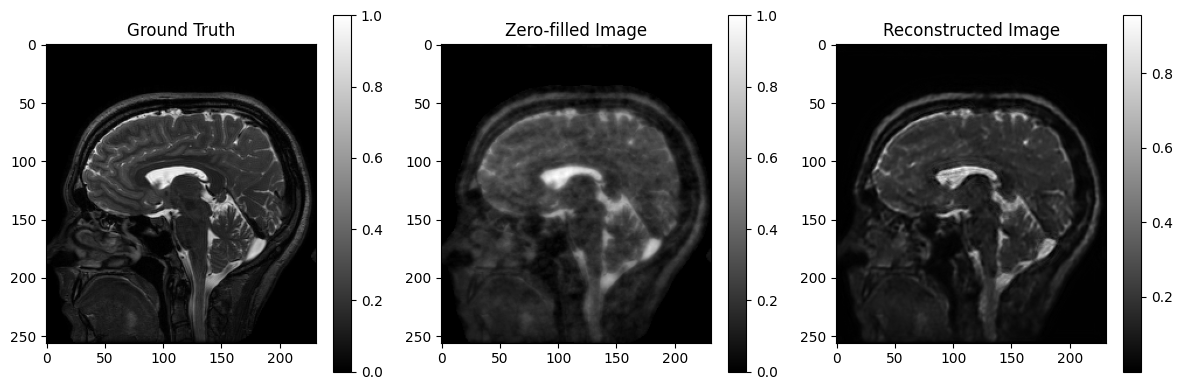

In [21]:
# Evaluation
model.eval()
with torch.no_grad():
    x_bi_test_tensor = torch.from_numpy(x_bi_test).to(device)
    reconstructed_images = model(x_bi_test_tensor).cpu().numpy()

# Calculate PSNR and SSIM values
psnr_values = []
ssim_values = []
for original, reconstructed in zip(x_i_test, reconstructed_images):
    original_magnitude = np.abs(original[0] + 1j * original[1])
    reconstructed_magnitude = np.abs(reconstructed[0] + 1j * reconstructed[1])

    psnr_value = psnr(original_magnitude, reconstructed_magnitude, data_range=original_magnitude.max() - original_magnitude.min())
    psnr_values.append(psnr_value)

    ssim_value = ssim(original_magnitude, reconstructed_magnitude, data_range=original_magnitude.max() - original_magnitude.min(), win_size=7)
    ssim_values.append(ssim_value)

avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
print("Average PSNR:", avg_psnr)
print("Average SSIM:", avg_ssim)

# Plot sample images
def plot_images(normalized_x_i, x_bi, reconstructed_images):
    plt.figure(figsize=(12, 4))

    # Plot Ground Truth Image
    plt.subplot(1, 3, 1)
    ground_truth_complex = normalized_x_i[0, 0] + 1j * normalized_x_i[0, 1]
    plt.imshow(np.abs(ground_truth_complex), cmap='gray')
    plt.title('Ground Truth')
    plt.colorbar()

    # Plot Zero-filled Image
    plt.subplot(1, 3, 2)
    zero_filled_complex = x_bi[0, 0] + 1j * x_bi[0, 1]
    plt.imshow(np.abs(zero_filled_complex), cmap='gray')
    plt.title('Zero-filled Image')
    plt.colorbar()

    # Plot Reconstructed Image
    plt.subplot(1, 3, 3)
    reconstructed_complex = reconstructed_images[0, 0] + 1j * reconstructed_images[0, 1]
    magnitude = np.abs(reconstructed_complex)
    plt.imshow(magnitude, cmap='gray')
    plt.title('Reconstructed Image')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

plot_images(x_i_test, x_bi_test, reconstructed_images)